`DataFrame`s and `Series` support all the usual math operations, addition, multiplaction, etc.
numpy `ufuncs` e.g. `np.log` can also be used as expected.

In [2]:
df = pd.DataFrame(np.random.uniform(0, 10, size=(3, 3)))
df ** 2

,0,1,2
0,49.500290,67.566994,27.629822
1,37.454745,16.541187,9.434132
2,86.584665,26.915426,59.156380


In [3]:
df

,0,1,2
0,7.035644,8.219914,5.256408
1,6.120028,4.067086,3.071503
2,9.305088,5.188008,7.691318


In [7]:
np.log(df)

,0,1,2
0,1.950989,2.106560,1.659448
1,1.811567,1.402927,1.122167
2,2.230561,1.646350,2.040092


The power of pandas comes with operations between Series and DataFrames. Pandas will automatically align by label.

In [8]:
df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]})

df1 + df2

,A,B
0,3,5
1,6,9
2,9,15


In [9]:
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]}, index=[2, 0, 1])
df2

,A,B
2,2,1
0,4,4
1,6,9


In [10]:
df1 + df2

,A,B
0,5,8
1,8,14
2,5,7


In [11]:
df3 = pd.DataFrame(np.random.randn(10, 2), columns=['A', 'B'])
df3

,A,B
0,-0.366494,0.212092
1,0.871755,-1.189998
2,0.051994,0.442431
3,-1.875364,0.160673
4,0.953643,-0.992227
5,0.512379,-0.241708
6,1.458906,-0.316900
7,-0.280328,0.218080
8,0.751476,-1.354936
9,0.598012,0.960643


In [12]:
df1 + df3

,A,B
0,0.633506,4.212092
1,2.871755,3.810002
2,3.051994,6.442431
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [21]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from pandas_datareader import data
from pandas.io import data

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_rows = 10
sns.set_style('ticks')

In [44]:
gdp = data.DataReader("GDPA", data_source='fred', start='1929', end='2014').squeeze()
cpi = data.DataReader("CPIAUCSL", data_source='fred', start='1947-01', end='2015-05').squeeze()
rec = data.DataReader('USREC', data_source='fred', start='1854-12-01', end='2014-08-01').squeeze()

In [29]:
gdp.to_csv('data/gdp.csv', header=True)
cpi.to_csv('data/cpi.csv', header=True)

In [17]:
gdp = pd.read_csv('data/gdp.csv', index_col=0, parse_dates=True).squeeze()

In [23]:
gdp.head()

DATE
1929-01-01    104.6
1930-01-01     92.2
1931-01-01     77.4
1932-01-01     59.5
1933-01-01     57.2
Name: GDPA, dtype: float64

In [72]:
from cytoolz import partitionby

In [63]:
is_rec = rec[rec == 1]

In [83]:
next(rec.iteritems())

(Timestamp('1854-12-01 00:00:00'), 1)

In [109]:
from itertools import chain

In [113]:
groups = (partitionby(lambda x: x[1] == 1, rec.iteritems()))
recessions = filter(lambda x: x[0][1] == 1, groups)
spans = [(months[0][0], months[-1][0]) for months in recessions]
# spans = list(chain.from_iterable(spans))

In [139]:
def add_rec_bars(ax=None):
    ax = ax or plt.gca()
    for span in spans:
        ax.fill_between(span, *ax.get_ylim(), color='k', alpha=.25)
    return ax

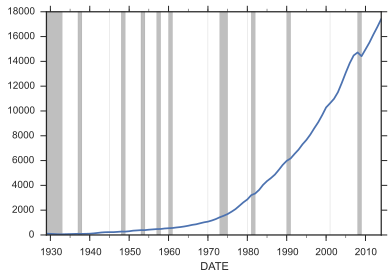

In [117]:
ax = gdp.plot()
add_rec_bars(ax)

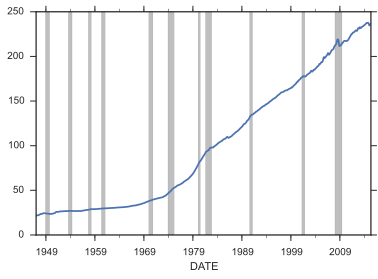

In [118]:
ax = cpi.plot()
add_rec_bars(ax)

In [119]:
new_base = cpi.loc['2009'].mean()
new_base

214.56466666666668

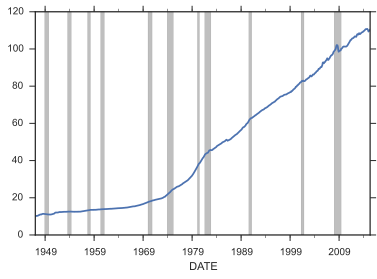

In [141]:
cpi09 = cpi / new_base * 100
cpi09.plot()
add_rec_bars();

# Alignment

We've been adding numbers and doing `ufuncs` on DataFrames and Series. Big deal, right?

Let's say we want real GDP (adjusted for inflation).

\begin{equation}
    rGDP_t = \frac{GDP_t}{CPI_t}
\end{equation}

Problem: our CPI is monthly but GDP is annual. Also the GDP series starts and stops before CPI. Pandas makes it somewhat easy to select the right months...

In [144]:
cpi09[(cpi09.index.month == 1) & (cpi09.index.year <= 2014)]

DATE
1947-01-01     10.010968
1948-01-01     11.036300
1949-01-01     11.190100
1950-01-01     10.957070
1951-01-01     11.828602
                 ...    
2010-01-01    101.362449
2011-01-01    103.068228
2012-01-01    106.149350
2013-01-01    107.866781
2014-01-01    109.583746
Name: CPIAUCSL, dtype: float64

In [135]:
gdp[gdp.index.year >= 1947] / cpi09[(cpi09.index.month == 1) & (cpi09.index.year <= 2014)]

DATE
1947-01-01     24.962621
1948-01-01     24.899650
1949-01-01     24.378693
1950-01-01     27.397836
1951-01-01     29.361036
                 ...    
2010-01-01    147.632582
2011-01-01    150.559491
2012-01-01    152.268478
2013-01-01    155.451936
2014-01-01    158.955142
dtype: float64

... but that's unneccesary. The operations will automatically align for you.

In [146]:
(gdp / cpi09).loc['1947']

DATE
1947-01-01    24.962621
1947-02-01          NaN
1947-03-01          NaN
1947-04-01          NaN
1947-05-01          NaN
                ...    
1947-08-01          NaN
1947-09-01          NaN
1947-10-01          NaN
1947-11-01          NaN
1947-12-01          NaN
dtype: float64

The `NaN`s are missing value indicators. `NaN`s can crop up for many reasons, but in this case it's because the labels didn't overlap perfectly.

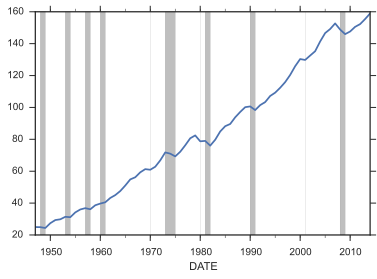

In [163]:
real_gdp = (gdp / cpi09).dropna().plot()
ax = real_gdp.plot()
add_rec_bars(ax)